## SARIMAX (your_data)

In [45]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

In [46]:
dates = pd.date_range(start='2020-01-01', periods=100, freq='M')
data = np.random.randint(100, 200, size=(100,))
exog_data = np.random.randint(10, 50, size=(100,))

In [47]:
df = pd.DataFrame(data, index=dates, columns=['value'])
df['exog'] = exog_data

In [48]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [49]:
from statsmodels.tsa.arima.model import ARIMA

model1=ARIMA(train['value'],order=(1,1,1))
model2=SARIMAX(train['value'],order=(1,1,1),seasonal_order=(1,1,1,12))

model3 = SARIMAX(train['value'],
                exog=train['exog'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))

In [50]:
model1_fit = model1.fit()
model2_fit=model2.fit()
model3_fit=model3.fit()
# Prédiction sur la période de test en incluant les valeurs exogènes
predictions1 = model1_fit.predict(start=test.index[0], end=test.index[-1], exog=test['exog'])
predictions2 = model2_fit.predict(start=test.index[0], end=test.index[-1], exog=test['exog'])
predictions3 = model3_fit.predict(start=test.index[0], end=test.index[-1], exog=test['exog'])

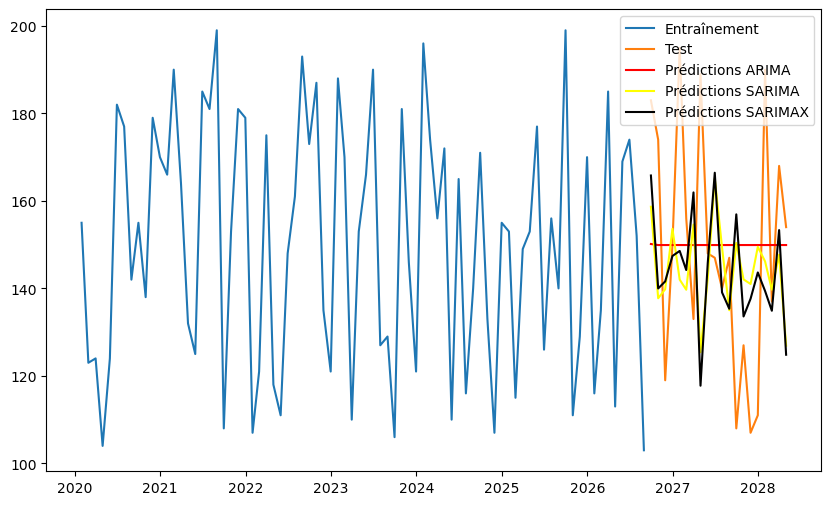

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['value'], label='Entraînement')
plt.plot(test.index, test['value'], label='Test')
plt.plot(test.index, predictions1, label='Prédictions ARIMA', color='red')
plt.plot(test.index, predictions2, label='Prédictions SARIMA', color='yellow')

plt.plot(test.index, predictions3, label='Prédictions SARIMAX', color='black')

plt.legend()
plt.show()

## SARIMAX(flights)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [3]:
df = sns.load_dataset('flights')

In [4]:
df['yearMonth'] = pd.to_datetime("01-"+df['month'].astype(str)+"-"+df['year'].astype(str))
df.set_index('yearMonth',inplace=True)
df.head()

,year,month,passengers
yearMonth,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


<Axes: xlabel='yearMonth', ylabel='passengers'>

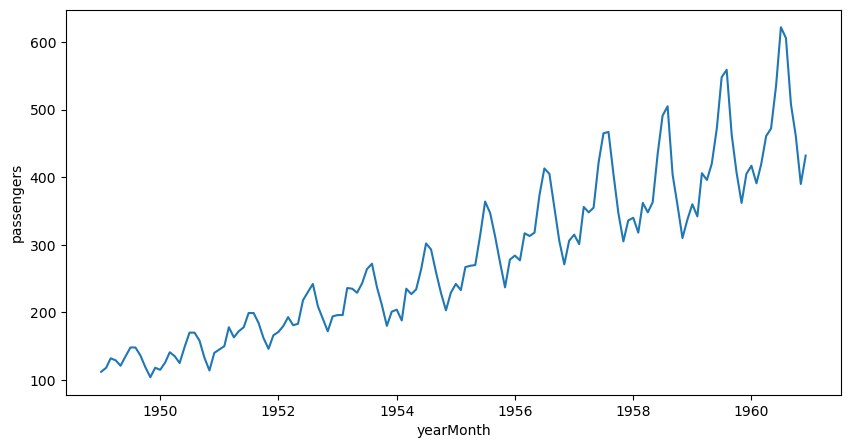

In [5]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.passengers)

In [6]:
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

result = adfuller(df['passengers'])

table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | 0.8153688792060547            |
| P-valeur       | 0.9918802434376411            |
| Conclusion     | La série est non stationnaire |


ADF Statistic: -2.829267
p-value: 0.054213
The 'Sales' column is non-stationary.


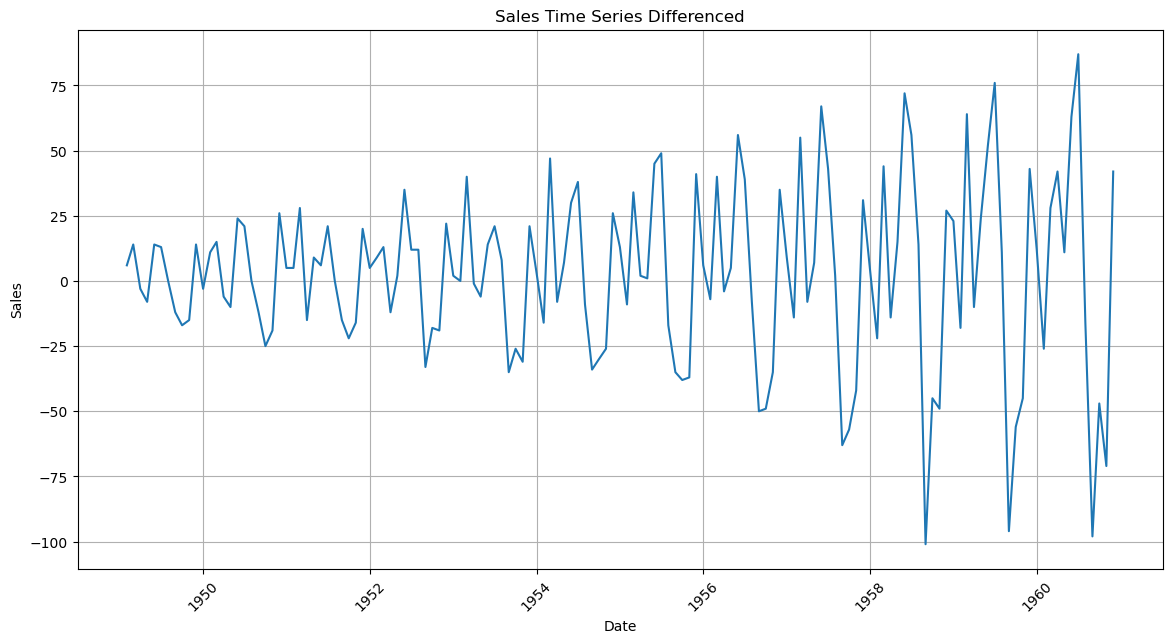

In [7]:
differenced = df['passengers'].diff()

result = adfuller(differenced.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("The 'Sales' column is stationary.")
else:
    print("The 'Sales' column is non-stationary.")
    
plt.figure(figsize=(14,7))
plt.plot(differenced)
plt.title('Sales Time Series Differenced')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [8]:
air_df = df[['passengers']]
air_df.head()

,passengers
yearMonth,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
airP = df[['passengers']].copy(deep=True)
airP['firstDiff'] = airP['passengers'].diff()
airP['Diff12'] = airP['passengers'].diff(12)

In [10]:
airP.head()

,passengers,firstDiff,Diff12
yearMonth,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN


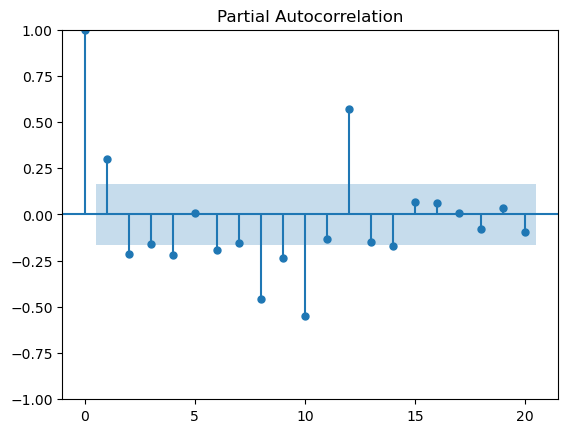

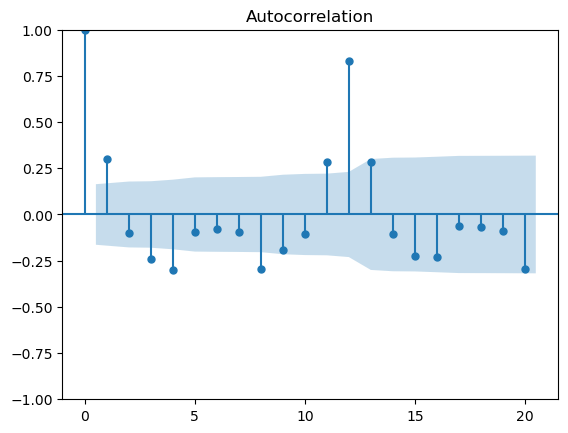

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(differenced.dropna(),lags=20);

plot_acf(differenced.dropna(),lags=20);

In [12]:
train_size=int(len(df)*0.8)
train=df[:train_size]
test=df[train_size:]

In [13]:
import itertools
p=d=q=range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq=[(x[0],x[1],x[2],12) for x in pdq]

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize the dictionary to store AIC values
metric_aic_dict = {}

# Loop through all combinations of (p, d, q) and (P, D, Q, S)
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit the SARIMAX model
            model = SARIMAX(train['passengers'], order=param, seasonal_order=seasonal_param)
            model_fit = model.fit(disp=False)

            # Calculate AIC
            aic = model_fit.aic

            # Store results in the dictionary
            metric_aic_dict[(param, seasonal_param)] = aic
        except:
            continue

C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency in

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Initialize the dictionary to store AIC values
metric_aic_dict2 = {}

# Loop through all combinations of (p, d, q) and (P, D, Q, S)
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            # Fit the SARIMAX model
            model = SARIMAX(train['passengers'], order=param, seasonal_order=seasonal_param)
            model_fit = model.fit()

            # Calculate AIC
            aic = model_fit.aic

            # Store results in the dictionary
            metric_aic_dict2[(param, seasonal_param)] = aic
        except:
            continue


C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency in

In [21]:
sorted_metric_aic_dict = {k: v for k, v in sorted(metric_aic_dict.items(), key=lambda x: x[1])}
sorted_metric_aic_dict2 = {k: v for k, v in sorted(metric_aic_dict2.items(), key=lambda x: x[1])}

In [44]:
sorted_metric_aic_dict

{((1, 1, 0), (0, 1, 0, 12)): 755.4993655556575,
 ((1, 1, 0), (1, 1, 0, 12)): 755.750271004056,
 ((1, 1, 0), (0, 1, 1, 12)): 755.9815409355406,
 ((0, 1, 1), (0, 1, 0, 12)): 756.0113506845998,
 ((1, 1, 1), (0, 1, 0, 12)): 756.021962795988,
 ((0, 1, 1), (1, 1, 0, 12)): 756.1655758988526,
 ((0, 1, 1), (0, 1, 1, 12)): 756.3802818130989,
 ((1, 1, 1), (1, 1, 0, 12)): 756.4056106676757,
 ((1, 1, 1), (0, 1, 1, 12)): 756.6285159375473,
 ((0, 1, 0), (1, 1, 0, 12)): 756.9591640166979,
 ((0, 1, 0), (0, 1, 1, 12)): 756.9881631129691,
 ((1, 1, 0), (1, 1, 1, 12)): 757.648689363343,
 ((0, 1, 0), (0, 1, 0, 12)): 757.8259224782274,
 ((0, 1, 1), (1, 1, 1, 12)): 758.1068769348959,
 ((1, 1, 1), (1, 1, 1, 12)): 758.2601973914717,
 ((0, 1, 0), (1, 1, 1, 12)): 758.9218654183766,
 ((1, 0, 1), (0, 1, 0, 12)): 765.5435737521829,
 ((1, 0, 1), (1, 1, 0, 12)): 766.0622703623061,
 ((1, 0, 1), (0, 1, 1, 12)): 766.2655160575335,
 ((1, 0, 0), (1, 1, 0, 12)): 766.4918731401594,
 ((1, 0, 1), (1, 1, 1, 12)): 766.5503743525

In [18]:
sorted_metric_aic_dict2

{((1, 1, 0), (0, 1, 0, 12)): 755.4993655556575,
 ((1, 1, 0), (1, 1, 0, 12)): 755.750271004056,
 ((1, 1, 0), (0, 1, 1, 12)): 755.9815409355406,
 ((0, 1, 1), (0, 1, 0, 12)): 756.0113506845998,
 ((1, 1, 1), (0, 1, 0, 12)): 756.021962795988,
 ((0, 1, 1), (1, 1, 0, 12)): 756.1655758988526,
 ((0, 1, 1), (0, 1, 1, 12)): 756.3802818130989,
 ((1, 1, 1), (1, 1, 0, 12)): 756.4056106676757,
 ((1, 1, 1), (0, 1, 1, 12)): 756.6285159375473,
 ((0, 1, 0), (1, 1, 0, 12)): 756.9591640166979,
 ((0, 1, 0), (0, 1, 1, 12)): 756.9881631129691,
 ((1, 1, 0), (1, 1, 1, 12)): 757.648689363343,
 ((0, 1, 0), (0, 1, 0, 12)): 757.8259224782274,
 ((0, 1, 1), (1, 1, 1, 12)): 758.1068769348959,
 ((1, 1, 1), (1, 1, 1, 12)): 758.2601973914717,
 ((0, 1, 0), (1, 1, 1, 12)): 758.9218654183766,
 ((1, 0, 1), (0, 1, 0, 12)): 765.5435737521829,
 ((1, 0, 1), (1, 1, 0, 12)): 766.0622703623061,
 ((1, 0, 1), (0, 1, 1, 12)): 766.2655160575335,
 ((1, 0, 0), (1, 1, 0, 12)): 766.4918731401594,
 ((1, 0, 1), (1, 1, 1, 12)): 766.5503743525

In [24]:
model = ARIMA(train['passengers'],order=(1,1,1))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
model2 = SARIMAX(train['passengers'],order=(1,1,0),seasonal_order=(0,1,0,12))
model2_fit = model2.fit()
prediction2 = model2_fit.predict(start=test.index[0],end=test.index[-1])

C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency in

In [25]:
from sklearn.metrics import mean_squared_error

mse1=np.sqrt(mean_squared_error(test['passengers'],prediction))
mse2=np.sqrt(mean_squared_error(test['passengers'],prediction2))
mse1,mse2

(97.49961969523241, 35.082813036167416)

In [26]:
exog_dataa=pd.read_csv("airline-passengerscatastrophe.csv")

In [27]:
exog_dataa.head()

,Month,Passagers_catastrophe
0,1949-01,80
1,1949-02,86
2,1949-03,100
3,1949-04,97
4,1949-05,89


In [29]:
df = sns.load_dataset('flights')
df['exoge']=exog_dataa['Passagers_catastrophe']

In [30]:
df.head()

,year,month,passengers,exoge
0,1949,Jan,112,80
1,1949,Feb,118,86
2,1949,Mar,132,100
3,1949,Apr,129,97
4,1949,May,121,89


In [32]:
train=df[:train_size]
test=df[train_size:]

In [37]:
df['yearMonth'] = pd.to_datetime("01-"+df['month'].astype(str)+"-"+df['year'].astype(str))
df.set_index('yearMonth',inplace=True)
df.head()

,year,month,passengers,exoge
yearMonth,,,,
1949-01-01,1949,Jan,112,80
1949-02-01,1949,Feb,118,86
1949-03-01,1949,Mar,132,100
1949-04-01,1949,Apr,129,97
1949-05-01,1949,May,121,89


In [40]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Supposons que df est votre DataFrame initial
train_size = int(len(df) * 0.8)  # Par exemple, 80% pour l'entraînement et 20% pour le test
train = df[:train_size]
test = df[train_size:]

# Convertir les colonnes 'year' et 'month' en une colonne 'yearMonth' de type datetime
df['yearMonth'] = pd.to_datetime("01-" + df['month'].astype(str) + "-" + df['year'].astype(str))
df.set_index('yearMonth', inplace=True)

# Afficher les premières lignes du DataFrame pour vérification
print(df.head())

# Entraînement du modèle SARIMAX avec variable exogène pour la période d'entraînement
model3 = SARIMAX(train['passengers'],
                 order=(1, 1, 0),
                 seasonal_order=(0, 1, 0, 12),
                 exog=train['exoge'])  # Exogène pour la période d'entraînement
model3_fit = model3.fit()

# Prédiction sur la période de test en incluant les données exogènes pour cette période
prediction3 = model3_fit.predict(start=test.index[0],
                                 end=test.index[-1],
                                 exog=test['exoge'])  # Exogène pour la période de test

# Afficher les prédictions
print(prediction3.head())


            year month  passengers  exoge
yearMonth                                
1949-01-01  1949   Jan         112     80
1949-02-01  1949   Feb         118     86
1949-03-01  1949   Mar         132    100
1949-04-01  1949   Apr         129     97
1949-05-01  1949   May         121     89
1958-08-01    505.0
1958-09-01    404.0
1958-10-01    359.0
1958-11-01    310.0
1958-12-01    337.0
Freq: MS, Name: predicted_mean, dtype: float64


C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Catello\Programmes\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
np.sqrt(mean_squared_error(test['passengers'],prediction3))

0.0

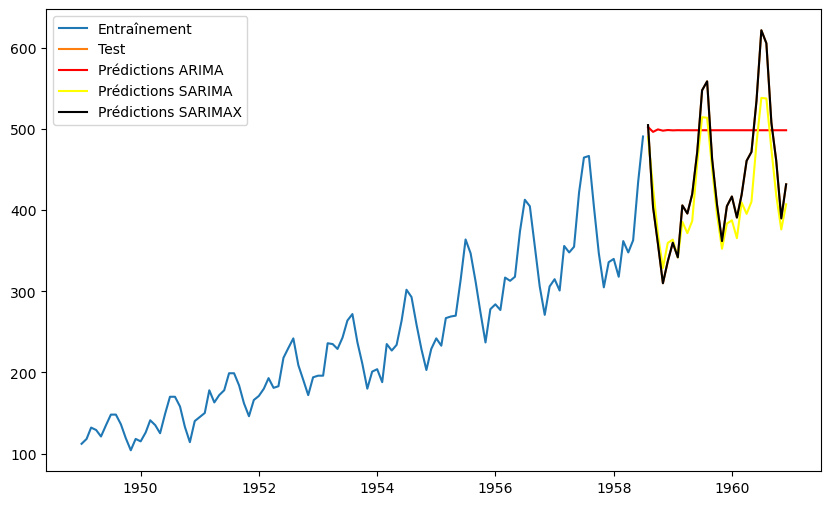

In [42]:

import matplotlib.pyplot as plt



# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['passengers'], label='Entraînement')
plt.plot(test.index, test['passengers'], label='Test')
plt.plot(test.index, prediction, label='Prédictions ARIMA', color='red')
plt.plot(test.index, prediction2, label='Prédictions SARIMA', color='yellow')
plt.plot(test.index, prediction3, label='Prédictions SARIMAX', color='black')

plt.legend()
plt.show()


## SARIMAX(shampoo_with_exog)

In [86]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

file_path = "C:\\Users\\Catello\\Desktop\\IAMDS2\\Statistiques\\shampoo_with_exog.csv"
df = pd.read_csv(file_path)

In [87]:
df.head()

,Month,Sales,Inflation
0,1-Jan,266.0,1
1,2-Jan,145.9,3
2,3-Jan,183.1,5
3,4-Jan,119.3,5
4,5-Jan,180.3,4


In [88]:
df=df.set_index('Month')

In [91]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("The 'Sales' column is stationary.")
else:
    print("The 'Sales' column is non-stationary.")

ADF Statistic: 3.060142
p-value: 1.000000
The 'Sales' column is non-stationary.


In [92]:
differenced = df['Sales'].diff()
differenced.head()

Month
1-Jan      NaN
2-Jan   -120.1
3-Jan     37.2
4-Jan    -63.8
5-Jan     61.0
Name: Sales, dtype: float64

ADF Statistic: -7.249074
p-value: 0.000000
The 'Sales' column is stationary.


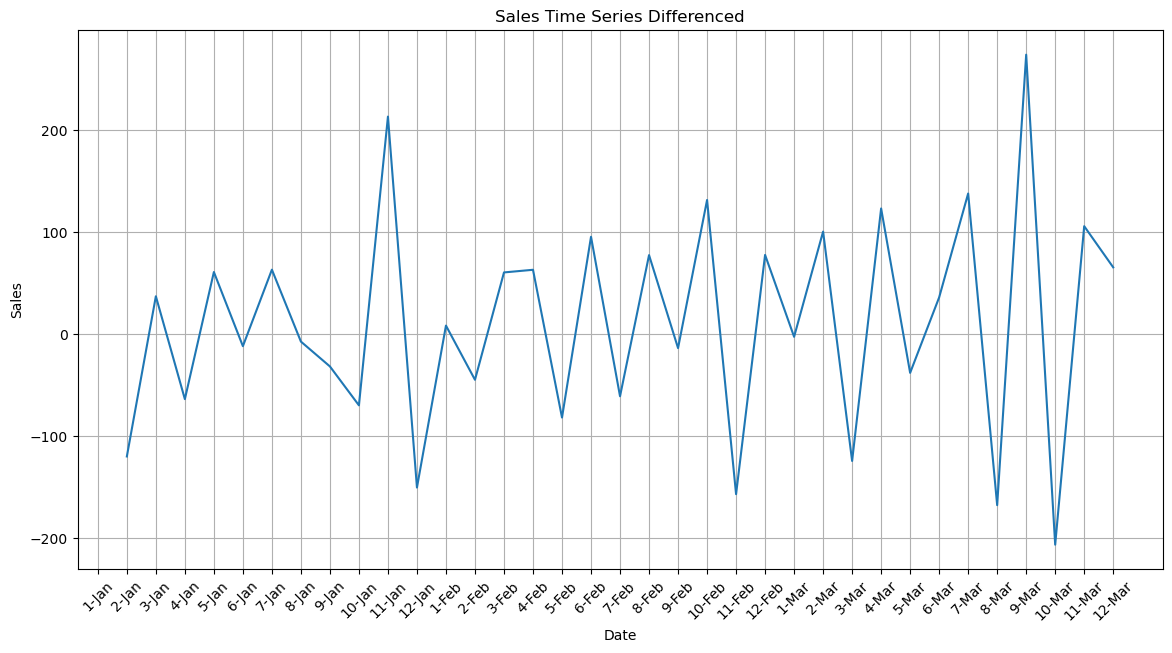

In [93]:
result = adfuller(differenced.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("The 'Sales' column is stationary.")
else:
    print("The 'Sales' column is non-stationary.")
    
plt.figure(figsize=(14,7))
plt.plot(differenced)
plt.title('Sales Time Series Differenced')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

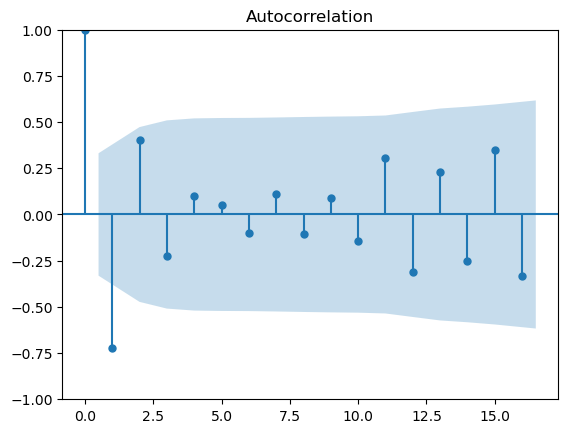

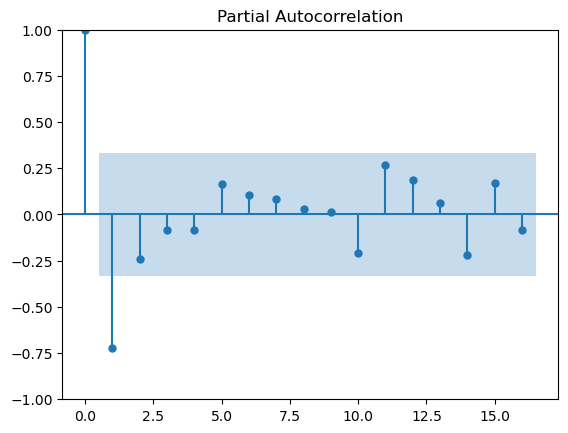

In [94]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(differenced.dropna())
plt.show()

plot_pacf(differenced.dropna())
plt.show()

In [95]:
train_size=int(0.8*len(df))
train=df[:train_size]
test=df[train_size:]

In [96]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Sales'],order=(1,1,1))
model_fit=model.fit()

In [97]:
predictions=model_fit.predict(start=train_size,end=len(df)-1)

In [98]:
from sklearn.metrics import mean_squared_error

mse=mean_squared_error(test['Sales'],predictions)
mse.round(2)

31017.7

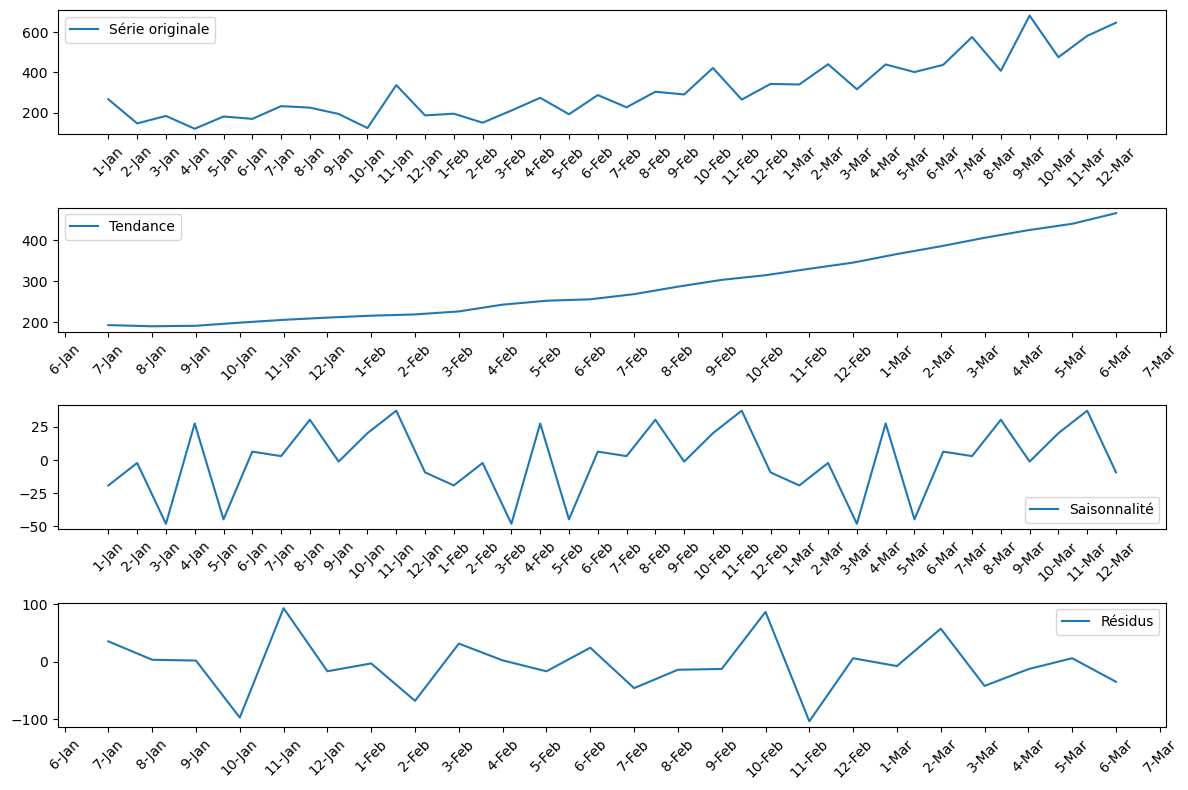

In [99]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Sales'], label='Série originale')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.subplot(414)
plt.plot(residual, label='Résidus')
plt.legend(loc='best')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [100]:
from statsmodels.tsa.stattools import adfuller

# Appliquer le test ADF sur la composante saisonnière
result = adfuller(decomposition.seasonal.dropna())

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] <= 0.05:
    print("The 'Sales' column is stationary.")
else:
    print("The 'Sales' column is non-stationary.")


ADF Statistic: -196415411124014.968750
p-value: 0.000000
The 'Sales' column is stationary.


In [101]:
differenced2=df['Sales'].diff(12)

In [102]:
len(differenced2.dropna())

24

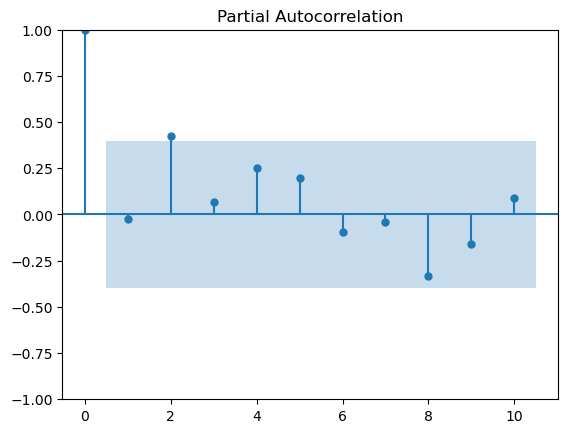

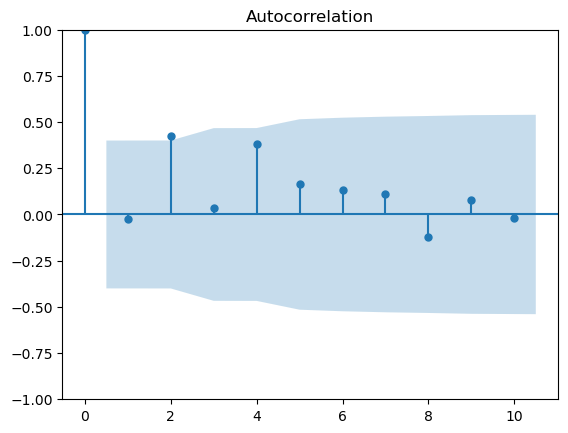

In [103]:
plot_pacf(differenced2.dropna(), lags=10)
plt.show()
plot_acf(differenced2.dropna(), lags=10)
plt.show()


In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model2=SARIMAX(train['Sales'],order=(1,1,1),seasonal_order=(0,1,1,12))
model2_fit=model2.fit()

In [105]:
predictions2=model2_fit.predict(start=train_size,end=len(df)-1)
mse2=mean_squared_error(predictions2,test['Sales'])

In [106]:
df.head()

,Sales,Inflation
Month,,
1-Jan,266.0,1
2-Jan,145.9,3
3-Jan,183.1,5
4-Jan,119.3,5
5-Jan,180.3,4


In [107]:
model3=SARIMAX(train['Sales'],exog_data=df['Inflation'],order=(1,1,1),seasonal_order=(1,1,1,12))
model3_fit=model3.fit()

In [109]:
predictions3=model3_fit.predict(start=train_size,end=len(df)-1)
mse3=mean_squared_error(predictions3,test['Sales'])
mse3.round(2)

19118.82